In [4]:
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as tts
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy as dp
import time 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import dataloader as dt
import allmodel as am
from scipy import signal as S
from torcheval.metrics.functional import multiclass_f1_score as f1
from torcheval.metrics import BinaryAUPRC
from sklearn.metrics import average_precision_score as f2
import torchmetrics
from torchmetrics import Accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def trainCNNClassifier(model,dataloader,testdataloader,epochs=10,lr=0.0001,cuda=True):
    his=[]
    acc=[]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy_metric = Accuracy(task="multiclass", num_classes=4).cuda()
    criterion = nn.CrossEntropyLoss()
    if cuda:
        model = model.train().cuda()
    else:
        model = model.train()
    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0
        model.train()
        for batch_inputs, batch_targets in dataloader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_inputs)

            # Compute the loss
            loss = criterion(outputs, batch_targets)

            #loss = (loss_s+loss_e)/2
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track the total loss
            total_loss += loss.item()
            his.append(loss.item())
        # Calculate average loss for the epoch
        avg_loss = total_loss / len(dataloader)

        model.eval()  # Set the model to evaluation mode
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            
            for val_inputs, val_labels in testdataloader:
                
                val_outputs = model(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_predictions.extend(val_preds.cpu().numpy())
                val_true_labels.extend(val_labels.cpu().numpy())
        

        # Calculate validation accuracy using the accuracy metric
        val_accuracy = accuracy_metric(torch.tensor(val_predictions), torch.tensor(val_true_labels))
        acc.append(val_accuracy.item())

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        
        """with torch.no_grad():
            for val_inputs, val_labels in testdataloader:
                
                
                val_outputs = model(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                
                val_accuracy = accuracy_metric(val_preds, val_labels)
                acc.append(val_accuracy.item())
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f},  Accuracy: {val_accuracy}")"""
        
    return model,his,acc

In [6]:
d = dt.Dataloader(200,1)
d.split(['Person (1)','Person (2)','Person (3)'])
d.load()
d.binary_labels()


In [7]:
_,DataC,_,_,_,_,clabels,_,TestDataC,_,_,_,_,tclabels = d.fetch(10,200,Gyro=True)#,ToFilter=False,scale=False)

(2890328, 6)
Filtering Signal
Adding magnitude as feature
Adding filtered Gyro sensor data
Data shape : torch.Size([2890328, 8])
Test Data shape :torch.Size([408364, 8])


tensor(0., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(2., dtype=torch.float64)
tensor(3., dtype=torch.float64)


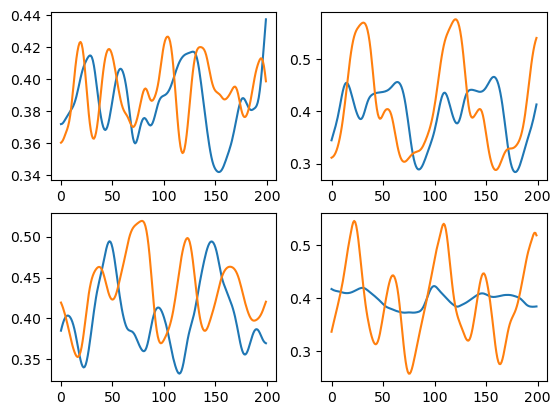

In [8]:
i=1500
ch=5
plt.subplot(2,2,1)
plt.plot(DataC[0+i,ch])
plt.plot(TestDataC[0+i,ch])
print(tclabels[0+i])

plt.subplot(2,2,2)
plt.plot(DataC[102091+i,ch])
plt.plot(TestDataC[102091+i,ch])
print(tclabels[102091+i])

plt.subplot(2,2,3)
plt.plot(DataC[(102091*2)+i,ch])
plt.plot(TestDataC[(102091*2)+i,ch])
print(tclabels[(102091*2)+i])

plt.subplot(2,2,4)
plt.plot(DataC[(102091*3)+i,ch])
plt.plot(TestDataC[(102091*3)+i,ch])
print(tclabels[(102091*3)+i])

In [9]:
num_classes=4
channel = 8
batch_size=1024
ws=200

In [265]:
del trdata,tedata

In [10]:

dataset = torch.utils.data.TensorDataset(DataC.float().cuda(), clabels.type(torch.LongTensor).cuda())

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [11]:
testdataset = torch.utils.data.TensorDataset(TestDataC.float().cuda(), tclabels.type(torch.LongTensor).cuda())
testdataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=True)

In [12]:

# Create an instance of the LSTM network
#model = am.CNN2h(ws,channel,(1,4,200)).cuda()
model = am.CNN_class(num_classes,channel,(1,channel,ws))

In [25]:
model

CNN_class(
  (block1): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (block2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=6272, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [13]:
model,his,acc = trainCNNClassifier(model,dataloader,testdataloader,epochs=15,cuda=True)

Epoch [1/15], Loss: 0.1150, Validation Accuracy: 0.7034
Epoch [2/15], Loss: 0.0356, Validation Accuracy: 0.7238
Epoch [3/15], Loss: 0.0256, Validation Accuracy: 0.7137
Epoch [4/15], Loss: 0.0207, Validation Accuracy: 0.7058
Epoch [5/15], Loss: 0.0173, Validation Accuracy: 0.7527
Epoch [6/15], Loss: 0.0149, Validation Accuracy: 0.7224
Epoch [7/15], Loss: 0.0131, Validation Accuracy: 0.7239
Epoch [8/15], Loss: 0.0122, Validation Accuracy: 0.7140
Epoch [9/15], Loss: 0.0108, Validation Accuracy: 0.7337
Epoch [10/15], Loss: 0.0103, Validation Accuracy: 0.7085
Epoch [11/15], Loss: 0.0097, Validation Accuracy: 0.7098
Epoch [12/15], Loss: 0.0093, Validation Accuracy: 0.7133
Epoch [13/15], Loss: 0.0086, Validation Accuracy: 0.7060
Epoch [14/15], Loss: 0.0082, Validation Accuracy: 0.7102
Epoch [15/15], Loss: 0.0077, Validation Accuracy: 0.7169


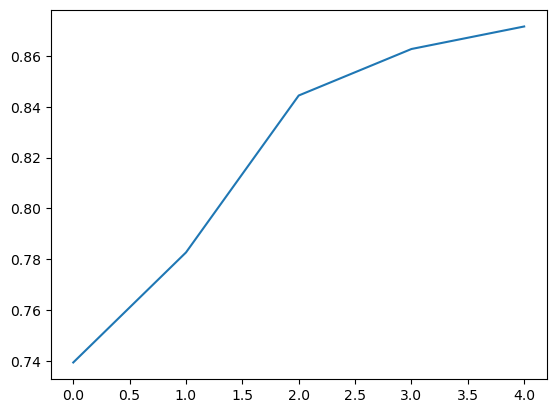

In [274]:
plt.plot(acc)

In [14]:
model = model.eval().cpu()
test_pred = torch.zeros((TestDataC.shape[0]))
bs=1024
for i in range(0,int(TestDataC.shape[0]/1),bs):
    test_pred[i:i+bs] = torch.argmax(model(TestDataC[i:i+bs]),axis=1)
    #print(torch.argmax(model(TestDataC[i:i+bs]),axis=1))
    #break


In [32]:
torch.argmax(model.eval().cpu()(TestDataC[55000:55001])),tclabels[55000]

(tensor(3), tensor(0., dtype=torch.float64))

In [22]:
model = model.eval().cpu()
train_pred = torch.zeros((DataC.shape[0]))
bs=1024
for i in range(0,int(DataC.shape[0]/1),bs):
    train_pred[i:i+bs] = torch.argmax(model(DataC[i:i+bs]),axis=1)

In [15]:
TestDataC[i:i+bs].shape

torch.Size([256, 8, 200])

In [176]:
f1(tclabels,test_pred,num_classes=4)

tensor(0.5268)

In [81]:
torch.unique(test_pred,return_counts=True)
#torch.unique(train_pred,return_counts=True)

(tensor([0., 1., 2., 3.]), tensor([ 27735,  93498,  12054, 274877]))

In [181]:
from torcheval.metrics.functional import multiclass_precision as per
per(tclabels,test_pred,num_classes=4),per(clabels,train_pred,num_classes=4)

(tensor(0.5268), tensor(0.9605))

In [15]:
from torcheval.metrics.functional import multiclass_accuracy as ma
ma(tclabels,test_pred)#,ma(clabels,train_pred)

tensor(0.7169)

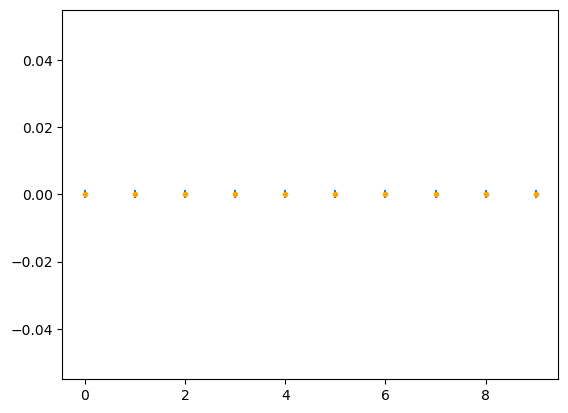

In [21]:
plt.scatter(range(10),tclabels[:10],marker='|')
plt.scatter(range(10),test_pred[:10],marker='.',c='orange')

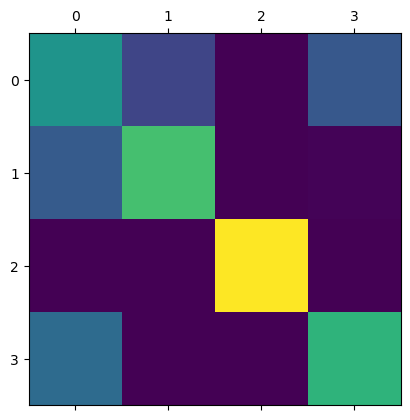

In [16]:
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)
mat=confmat(test_pred,tclabels)
plt.matshow(mat)

In [17]:
mat

tensor([[ 52633,  21358,      0,  28100],
        [ 29170,  71959,    100,    862],
        [   129,     14, 101865,     83],
        [ 35779,     21,      0,  66291]])

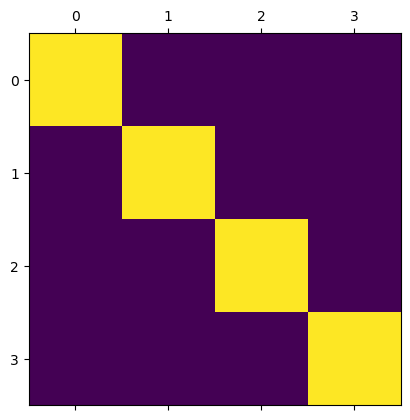

In [23]:
mat1=confmat(train_pred,clabels)
plt.matshow(mat1)

In [24]:
mat1

tensor([[720844,   1738,      0,      0],
        [    17, 722285,      0,    280],
        [     0,      0, 722541,     41],
        [     0,    542,      1, 722039]])